In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netCDF4

In [3]:
#STEP1 Extract data from DS, understand what it there.
import numpy as np
import os, sys, importlib
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from time import time as clock

In [4]:
DRIVE_ROOT = "/content/drive/MyDrive/DynamicsTensors"
REPO_ROOT  = f"{DRIVE_ROOT}/bstt2"
DATA_DIR   = f"{DRIVE_ROOT}/data"
OUT_DIR    = f"{DRIVE_ROOT}/outputs"

EXP = "basetests"
RUN_DIR = f"{OUT_DIR}/{EXP}"

os.makedirs(RUN_DIR, exist_ok=True)
if REPO_ROOT not in sys.path: sys.path.append(REPO_ROOT)

print("Repo:", REPO_ROOT)
print("Data:", DATA_DIR)
print("Run dir:", RUN_DIR)
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")

from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours

Repo: /content/drive/MyDrive/DynamicsTensors/bstt2
Data: /content/drive/MyDrive/DynamicsTensors/data
Run dir: /content/drive/MyDrive/DynamicsTensors/outputs/basetests


In [5]:
for path in [train_path, test_path]:
    print("\n=== File:", os.path.basename(path), "===\n")
    ds = Dataset(path, "r")

    # Basic dims and time
    num_dim   = ds.dimensions.get("num_dim").size        if "num_dim"   in ds.dimensions else None
    num_nodes = ds.dimensions.get("num_nodes").size      if "num_nodes" in ds.dimensions else None
    num_elem  = ds.dimensions.get("num_elem").size       if "num_elem"  in ds.dimensions else None
    n_steps   = ds.dimensions.get("time_step").size      if "time_step" in ds.dimensions else 0
    print(f"num_dim={num_dim}, num_nodes={num_nodes}, num_elem={num_elem}, time_steps={n_steps}")

    # Time
    if "time_whole" in ds.variables:
        times = ds.variables["time_whole"][:]
        print(f"time_whole: shape={times.shape} example={times[:3]}")

    if "name_nod_var" in ds.variables:
        names = chartostring(ds.variables["name_nod_var"][:]).tolist()
        names = [s.strip() for s in names]
        print("nodal var names:", names)
    else:
        print("nodal var names: (none declared)")

    keys = sorted(ds.variables.keys())
    print("\nvariable keys (subset):", keys[:15], "..." if len(keys)>15 else "")

    nod_keys = [k for k in keys if k.startswith("vals_nod_var")]
    if nod_keys:
        k0 = nod_keys[0]
        print(f"\nExample nodal values: ds.variables['{k0}'][:] -> shape", ds.variables[k0].shape,
              "(expected (time_step, num_nodes))")

    for ckey in ["coordx","coordy","coordz"]:
        if ckey in ds.variables:
            print(f"{ckey}: shape", ds.variables[ckey].shape)

    conn_keys = [k for k in keys if k.startswith("connect")]
    if conn_keys:
        print("connectivity keys:", conn_keys[:5])

    ds.close()

print("\n# Extraction patterns :")
print("times      = ds.variables['time_whole'][:]                 # (time_step,)")
print("xcoord     = ds.variables.get('coordx')[:]                  # (num_nodes,) if present")
print("ycoord     = ds.variables.get('coordy')[:]                  # (num_nodes,) if present")
print("u_time     = ds.variables['vals_nod_var1'][:]               # (time_step, num_nodes) for 1st nodal var")
print("# map index→name: chartostring(ds.variables['name_nod_var'][:]).tolist()")



=== File: train_data.e ===

num_dim=2, num_nodes=6569, num_elem=6384, time_steps=5541
time_whole: shape=(5541,) example=[0. 1. 2.]
nodal var names: ['V_y', 'V_x', 'P']

variable keys (subset): ['connect1', 'coor_names', 'coordx', 'coordy', 'eb_names', 'eb_prop1', 'eb_status', 'elem_num_map', 'elem_ss1', 'elem_ss2', 'elem_ss3', 'elem_ss4', 'name_nod_var', 'node_num_map', 'qa_records'] ...

Example nodal values: ds.variables['vals_nod_var1'][:] -> shape (5541, 6569) (expected (time_step, num_nodes))
coordx: shape (6569,)
coordy: shape (6569,)
connectivity keys: ['connect1']

=== File: test_data_2.e ===

num_dim=2, num_nodes=6569, num_elem=6384, time_steps=1409
time_whole: shape=(1409,) example=[0. 1. 2.]
nodal var names: ['V_y', 'V_x', 'P']

variable keys (subset): ['connect1', 'coor_names', 'coordx', 'coordy', 'eb_names', 'eb_prop1', 'eb_status', 'elem_num_map', 'elem_ss1', 'elem_ss2', 'elem_ss3', 'elem_ss4', 'name_nod_var', 'node_num_map', 'qa_records'] ...

Example nodal values: ds.v

In [6]:
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")
print("format:", name_scan(train_path))
###################################################
meta = inspect_fields(train_path)
print(meta)
times, coordx, coordy, Vx, Vy, P, V_stack = load_fields(train_path, t_start=0, t_count=None)
print("shape times:", times.shape)
print("shape coords:", coordx.shape, coordy.shape)
print("shape Vx/Vy/P:", Vx.shape, Vy.shape, P.shape)
print("shape V_stack:", V_stack.shape)

format: exodus
{'format': 'exodus', 'num_nodes': 6569, 'num_elems': 6384, 'time_steps': 5541, 'nodal_var_names': ['V_y', 'V_x', 'P'], 'time_key_guess': 'time_whole'}
shape times: (5541,)
shape coords: (6569,) (6569,)
shape Vx/Vy/P: (6569, 5541) (6569, 5541) (6569, 5541)
shape V_stack: (13138, 5541)


In [8]:
#plot_flow_snapshot(train_path, t_index = 44, quiver_frac=0.2)

In [9]:
#plot_heatmap_contours(train_path, t_index=2588, field="speed",    levels=100)

In [10]:
#Pressure heat map:
#plot_heatmap_contours(train_path, t_index=3300, field="pressure", levels=100)

### DS assembly and Plotting

In [42]:
# test set:
times, x, y, Vx, Vy, P, V = load_fields(train_path, t_start=0, t_count=5541)
print(times.shape, Vx.shape, Vy.shape, P.shape, V.shape)
#############################
DT = 1385 # one experiemnt per Re number! This Corresponds to RE = 300
DT_TEST = 250

# tr_idx_cut_low = 0 * DT + 1
# tr_idx_cut_high = 1 * DT  -1 - DT_TEST

# # RE = 400 ?
tr_idx_cut_low = 4034 + 1
tr_idx_cut_high = 4034 + 1385  -1 - DT_TEST

# RE = 100 ?
# tr_idx_cut_low = 0
# tr_idx_cut_high = 1219 - DT_TEST

# RE = 300 ?
# tr_idx_cut_low = 1222
# tr_idx_cut_high = 2588 - DT_TEST

times_test = times[tr_idx_cut_high:tr_idx_cut_high + DT_TEST] # time array is uniform,  but there are just indices (not real time)
Vx_test = Vx[:,tr_idx_cut_high:tr_idx_cut_high + DT_TEST]
Vy_test = Vy[:,tr_idx_cut_high:tr_idx_cut_high + DT_TEST]
V_test = V[:,tr_idx_cut_high:tr_idx_cut_high + DT_TEST]
############################
times = times[tr_idx_cut_low:tr_idx_cut_high]
Vx = Vx[:,tr_idx_cut_low:tr_idx_cut_high]
Vy = Vy[:,tr_idx_cut_low:tr_idx_cut_high]
V = V[:,tr_idx_cut_low:tr_idx_cut_high]
###########################
X =V[:,0:V.shape[1]-1]
Xprime = V[:,1:V.shape[1]]
assert X.shape == Xprime.shape


(5541,) (6569, 5541) (6569, 5541) (6569, 5541) (13138, 5541)


In [43]:
# Loading Test Data!
times_t, x_t, y_t, Vx_t, Vy_t, P_t, V_t = load_fields(test_path, t_start=0, t_count=5541)
print(times_t.shape, Vx_t.shape, Vy_t.shape, P_t.shape, V_t.shape)

(1409,) (6569, 1409) (6569, 1409) (6569, 1409) (13138, 1409)


In [44]:
### similarity matrix:
Vav = V - np.mean(V,axis = 1, keepdims=True) # shape [n, M]
sim_V = Vav.T @ Vav # shape [M,M] - this is small matrix!
UC,SC,VC = np.linalg.svd(sim_V, full_matrices=False) # one can esitmate eigenvalues and linear dimension.

In [45]:
cut_off_ind = 30
VC = VC[:,:cut_off_ind]
VC.shape

(1133, 30)

Spectral Energy: 99.82611207668214 % of 30


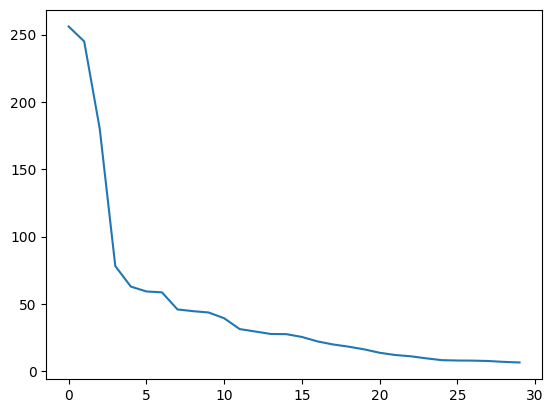

In [46]:

plt.plot(np.sqrt(SC[0:cut_off_ind]))
print(f'Spectral Energy: {100 * np.sum(SC[0:cut_off_ind])/np.sum(SC)} % of {cut_off_ind}')

In [47]:
# Data reorganization:
X =V[:,0:V.shape[1]-1] # shape [n,M]
Xprime = V[:,1:V.shape[1]] # shape [n,M]
assert X.shape == Xprime.shape

#DMD implimentation
def DMD_UNIF(data, r, demean = True, simplified  = True):
    """
    Exact DMD for uniformly sampled snapshots.
    Returns:
        eigvals : (r,) complex discrete eigenvalues λ
        Phi     : (n, r) complex DMD modes
        b       : (r,) complex modal apl.
        Atilde  : (r, r) reduced operator
    """
    if demean:
        data = data - data.mean(axis=1, keepdims=True)
    X =data[:,0:data.shape[1]-1] # we expect shape [n,M]
    Xprime = data[:,1:data.shape[1]] # we expect shape [n,M]

    if simplified:
        # caluclate siilarity matrix:
        sim_data = X.T @ X # shape [M,M] - this is small matrix!
        UC,SC,VC = np.linalg.svd(sim_data, full_matrices=False) # one can esitmate eigenvalues and linear dimension.
        sr   = np.sqrt(SC[:r]) # shape (r,)
        Vr = VC[:r,:].T # shape (M,r)
        Ur = X @ Vr @ np.diag(1.0/sr) # shape [n,r]
    else:
        U, s, VT = np.linalg.svd(X, full_matrices=False)  # standard SVD X = U s V^T
        Ur   = U[:, :r]                      # shape [n, r]
        sr   = s[:r]                         # shape [r,]
        Vr   = VT[:r, :].T                   # shape [M, r]  (this is Vr) as above


    # Atilde = Ur^T X' V_r Σ_r^{-1}
    XpVr = Xprime @ Vr                   # shape [n, r]
    XpVr_scaled = XpVr * (1.0 / sr)      # column-scale by s_r^{-1}
    Atilde = Ur.T @ XpVr_scaled          # (r, r)

    # Eigendecomposition in reduced space
    eigvals, W = np.linalg.eig(Atilde)   # dynamic matrix eigs,  W
    # Modes: Phi = X' V_r s_r^{-1} W
    Phi = XpVr_scaled @ W                # (n, r)

    # Amplitudes: robust least-squares on full modes ( robust replacement of pseudo - inverse for matrix Psi)
    x1 = X[:, 0]
    b, *_ = np.linalg.lstsq(Phi, x1, rcond=None)

    ##
    return eigvals, Phi, b, Atilde
#################################################
#################################################
# SVD above might have different signs, so values do have different sighns, but this do not affect an overall result.

In [48]:
#rank cut off
r_cut = 25
# simplified version is 3 rimes faster
#t_in = clock()
eigvals_sim, Phi_sim, b_sim, Atilde_sim = DMD_UNIF (V,r_cut, demean=True, simplified=True)
#t_out = clock()

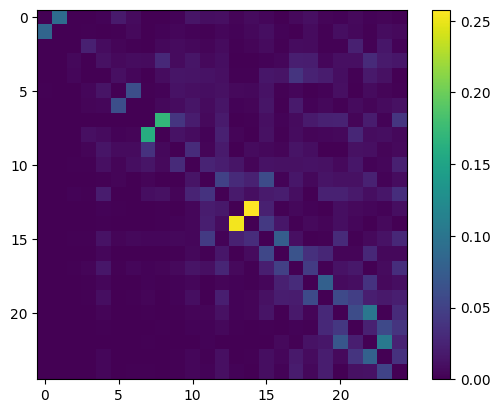

In [49]:
plt.imshow(np.abs(Atilde_sim - np.diag(np.diag(Atilde_sim))))
plt.colorbar()

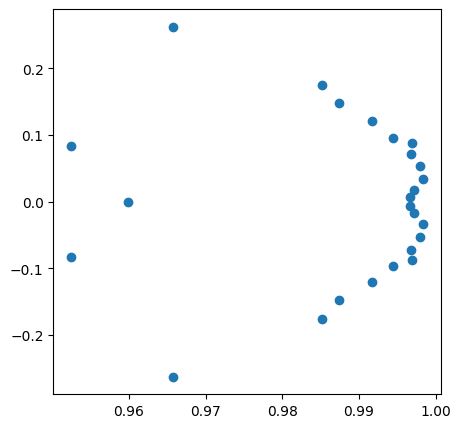

In [50]:
fig = plt.figure(figsize = (5,5))
plt.scatter(eigvals_sim.real, eigvals_sim.imag)

In [51]:
def load_triangulation(path):
    """
    Return matplotlib.tri.Triangulation for the first connectivity present.
    Supports triangles or quads (quads are split into two triangles).
    """
    ds = Dataset(path, "r")
    x = np.asarray(ds.variables["coordx"][:])
    y = np.asarray(ds.variables["coordy"][:])

    conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
    assert conn_keys, "No connectivity array ('connect*') found in file."
    conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1

    if conn.shape[1] == 3:
        tri_conn = conn
    elif conn.shape[1] == 4:
        tri_conn = np.vstack([conn[:, [0, 1, 2]],
                              conn[:, [0, 2, 3]]])
    else:
        ds.close()
        raise ValueError(f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4).")

    tri = mtri.Triangulation(x, y, triangles=tri_conn)
    ds.close()
    return tri

tri = load_triangulation(train_path)
def dmd_plot_modes_simple(lambdas, Phi, b, tri, time_arr, modes=(0, 1, 2),
                          layout="stacked", quiver_frac=0.03, cmap=None,
                          time_unit="arb"):
    """
    DMD plotter for unstructured meshes
    For each selected mode j:
      - left  : |phi_j| heatmap + quiver of Re{phi_j}
      - right : modal time signal s_j(t) = Re{ |b_j| * exp(ω_j (t - t0)) }
               with ω_j = log(λ_j) / Δt

    Args
    ----
    lambdas   : (r,) complex discrete-time eigenvalues of dynamics matrix Atilde
    Phi       : (2*N_nodes, r) complex DMD modes stacked as [Vx_nodes; Vy_nodes]
    b         : (r,) complex modal amplitudes
    tri       : matplotlib.tri.Triangulation (built once from your file)
    time_arr  : (T,) 1-D array of times (monotone; units given by time_unit)
    modes     : tuple/list of mode indices to plot
    layout    : "stacked" (default) or "interleaved" for Phi row layout
    quiver_frac : fraction of nodes used for quiver (e.g., 0.03 -> ~3%)
    cmap      : optional matplotlib colormap
    time_unit : string for labeling time units ("s", "ms", "dt", etc.)

    Returns
    -------
    fig : matplotlib Figure
    """
    dt = np.median(np.diff(time_arr))
    t0 = time_arr[0]
    t  = time_arr

    n_nodes = tri.x.size

    nrows = len(modes)
    fig, axes = plt.subplots(nrows, 2, figsize=(11, 3.2 * nrows))
    if nrows == 1:
        axes = np.array([axes])

    # arrow downsampling
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n_nodes, step)

    # Precompute a common vmax (98th percentile) for fair comparison
    mags_all = []
    for j in modes:
        theta = np.angle(b[j])
        phi_j = Phi[:, j] * np.exp(1j * theta)
        if layout == "stacked":
            u = phi_j[:n_nodes]
            v = phi_j[n_nodes:]
        else:
            uv = phi_j.reshape(n_nodes, 2)
            u, v = uv[:, 0], uv[:, 1]
        mags_all.append(np.sqrt(np.abs(u)**2 + np.abs(v)**2))
    #vmax = float(np.percentile(np.concatenate(mags_all), 98)) if mags_all else None

    for row, j in enumerate(modes):
        # -------- field panel --------
        ax_field = axes[row, 0]
        theta = np.angle(b[j])                 # phase-align so |b_j| is used in time panel
        bj_aligned = np.abs(b[j])
        phi_j = Phi[:, j] * np.exp(1j * theta)

        if layout == "stacked":
            u = phi_j[:n_nodes]
            v = phi_j[n_nodes:]
        elif layout == "interleaved":
            uv = phi_j.reshape(n_nodes, 2)
            u, v = uv[:, 0], uv[:, 1]
        else:
            raise ValueError("layout must be 'stacked' or 'interleaved'")

        mag = np.sqrt(np.imag(u)**2 + np.abs(v)**2)
        im = ax_field.tripcolor(tri, mag, shading="gouraud", cmap=cmap)
        ax_field.quiver(tri.x[q_idx], tri.y[q_idx], u.real[q_idx], v.real[q_idx],
                        angles="xy", scale_units="xy", scale=1, width=0.002, alpha=0.9)
        ax_field.set_aspect("equal", adjustable="box")
        ax_field.set_xticks([]); ax_field.set_yticks([])
        ax_field.set_title(f"Mode {j}: |φ|")
        cb = plt.colorbar(im, ax=ax_field, fraction=0.046, pad=0.04)
        cb.set_label("|φ|")

        # -------- time panel --------
        ax_time = axes[row, 1]
        lam = lambdas[j]
        if not np.isfinite(lam) or abs(lam) < 1e-12:
            wj = np.nan + 1j*np.nan
            s  = np.zeros_like(t)
            ax_time.plot(t, s, lw=1.8)
            ax_time.set_title(f"Mode {j}: λ≈0 (no dynamics)")
        else:
            wj = np.log(lam) / dt
            s  =  np.real(bj_aligned * np.exp(wj * (t - t0)))
            smag = np.abs(bj_aligned * np.exp(wj * (t - t0)))
            ax_time.plot(t, s, lw=1.8, label = 'Real part')
            ax_time.plot(t, smag, lw=1.8, label = 'Magnitude', alpha = 0.5)
            ax_time.legend()
            freq = np.imag(wj) / (2*np.pi)
            sig  = np.real(wj)
            ax_time.set_title(f"Mode {j}: f={freq:.3g} [{time_unit}⁻¹], σ={sig:.3g} [{time_unit}⁻¹]")

        ax_time.set_xlabel(f"time [{time_unit}]")
        ax_time.set_ylabel("modal signal")

    fig.suptitle("DMD modes & time dynamics (simple)", y=0.995, fontsize=12)
    fig.tight_layout()
    return fig




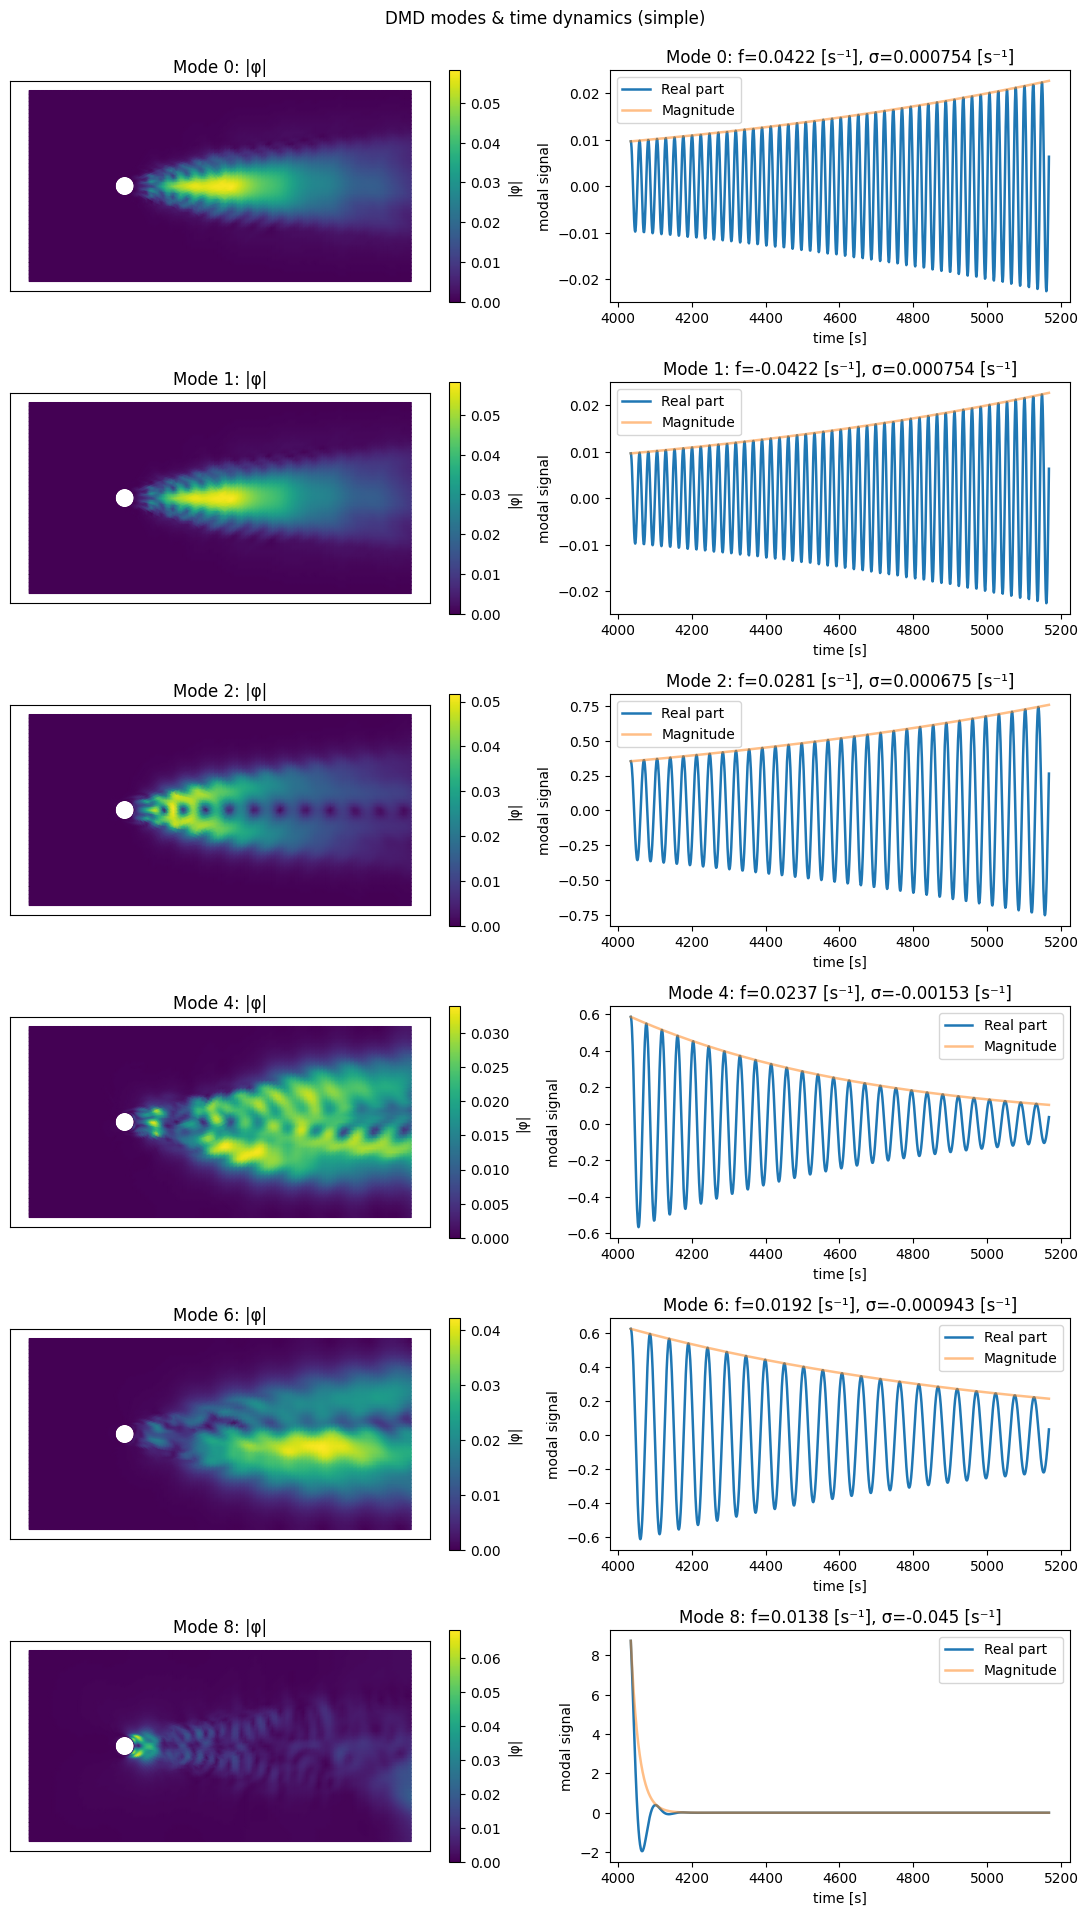

In [52]:
tri = load_triangulation(train_path)
fig = dmd_plot_modes_simple(eigvals_sim, Phi_sim, b_sim, tri, time_arr=times,
                            modes=(0,1,2,4,6,8), layout="stacked", quiver_frac=0.00,
                            time_unit="s")
plt.show()


In [53]:

def dmd_predict_modal_simple(Phi, lambdas, V_test, mean_train=None, times=None, dt=1.0):
    """
    Predict velocity snapshots with DMD in modal space.

    Inputs
    ------
    Phi        : (n, r) complex DMD modes (from training)
    lambdas    : (r,) complex DISCRETE-time eigenvalues λ (from training)
    V_test     : (n, T) stacked test data [Vx; Vy] (RAW, no de-meaning)
    mean_train : (n,) or None. The mean vector used during training (to add back).
    times      : (T,) or None. If provided, uses irregular Δt_k = t[k+1]-t[k].
    dt         : float. Time step if `times` is None.

    Returns
    -------
    V_pred_roll : (n, T) free-rollout predictions (x_hat_0 = V_test[:,0])
    V_pred_step : (n, T) one-step-ahead predictions (x_hat_k uses true x_{k-1})
    err_roll    : (T,) relative L2 error per step (rollout); err_roll[0]=np.nan
    err_step    : (T,) relative L2 error per step (one-step); err_step[0]=np.nan
    """
    X = V_test
    n, T = X.shape
    r = Phi.shape[1]
    assert Phi.shape[0] == n, "Phi shape mismatch with V_test"
    assert lambdas.shape == (r,), "lambdas must be shape (r,)"

    # Time steps
    if times is not None:
        t = np.asarray(times)
        assert t.shape == (T,), "times must have length T"
        dts = np.diff(t)  # length T-1
        dt_ref = float(np.median(dts))  # reference Δt used for λ→ω conversion
    else:
        dts = np.full(T-1, float(dt))
        dt_ref = float(dt)

    # Convert discrete eigenvalues (λ) to continuous rates
    omega = np.empty(r, dtype=complex)
    mask = np.abs(lambdas) > 1e-12
    omega[mask] = np.log(lambdas[mask]) / dt_ref
    omega[~mask] = (-np.inf + 0j)  # exp(ω*Δt) -> 0 for zero/near-zero λ

    # Training mean (used during training de-mean). If unknown, assume zero.
    mu = np.zeros(n) if mean_train is None else np.asarray(mean_train).reshape(-1)
    assert mu.shape[0] == n, "mean_train must have length n"

    # Center test data with the same mean used in training
    Xc = X - mu[:, None]

    # Pseudoinverse for coefficient estimation
    Phi_pinv = np.linalg.pinv(Phi)  # (r, n)

    # Allocate outputs
    V_pred_roll = np.empty_like(X, dtype=float)
    V_pred_step = np.empty_like(X, dtype=float)
    err_roll = np.full(T, np.nan, dtype=float)
    err_step = np.full(T, np.nan, dtype=float)

    # --- Free rollout -----------
    # init from first test frame
    c = Phi_pinv @ Xc[:, 0]                 # modal coeffs at k=0
    V_pred_roll[:, 0] = X[:, 0]             # align first frame with truth
    # propagate
    for k in range(T-1):
        c = c * np.exp(omega * dts[k])      # c_{k+1}
        x_hat = Phi @ c                     # centered prediction
        V_pred_roll[:, k+1] = np.real_if_close(x_hat + mu)
        # error at k+1
        denom = np.linalg.norm(X[:, k+1])
        if denom > 0:
            err_roll[k+1] = np.linalg.norm(V_pred_roll[:, k+1] - X[:, k+1]) / denom

    # --- One-step forward -------
    V_pred_step[:, 0] = X[:, 0]
    for k in range(T-1):
        c_k   = Phi_pinv @ Xc[:, k]                 # from TRUE x_k
        c_k1  = c_k * np.exp(omega * dts[k])        # advance
        x_hat = Phi @ c_k1
        V_pred_step[:, k+1] = np.real_if_close(x_hat + mu)
        denom = np.linalg.norm(X[:, k+1])
        if denom > 0:
            err_step[k+1] = np.linalg.norm(V_pred_step[:, k+1] - X[:, k+1]) / denom

    return V_pred_roll, V_pred_step, err_roll, err_step


def plot_velocity_true_vs_pred(tri, V_true, V_pred, t_index,
                               layout="stacked", quiver_frac=0.03, R = 400 ,cmap=None):
    """
    Side-by-side heatmaps with arrows for TRUE and PRED at a single time index.

    Inputs
    ------
    tri        : matplotlib.tri.Triangulation (your mesh)
    V_true     : (n, T) stacked [Vx; Vy] ground truth
    V_pred     : (n, T) stacked [Vx; Vy] prediction to compare
    t_index    : int, which frame to plot
    layout     : "stacked" (default) or "interleaved" for per-node packing
    quiver_frac: fraction of nodes to draw arrows (~0.03 = 3%)
    cmap       : optional colormap name

    Returns
    -------
    fig : matplotlib Figure
    """
    n_nodes = tri.x.size
    X1 = np.asarray(V_true); X2 = np.asarray(V_pred)
    assert X1.shape == X2.shape, "V_true and V_pred shapes must match"
    n, T = X1.shape
    assert n in (2*n_nodes, 2*n_nodes), "Expect stacked [Vx; Vy] layout"
    assert 0 <= t_index < T

    def split(vec):
        if layout == "stacked":
            u = vec[:n_nodes].real
            v = vec[n_nodes:].real
        elif layout == "interleaved":
            uv = vec.reshape(n_nodes, 2).real
            u, v = uv[:, 0], uv[:, 1]
        else:
            raise ValueError("layout must be 'stacked' or 'interleaved'")
        return u, v


    x1 = X1[:, t_index]
    x2 = X2[:, t_index]
    u1, v1 = split(x1); u2, v2 = split(x2)
    mag1 = np.hypot(u1, v1); mag2 = np.hypot(u2, v2)


    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n_nodes, step)


    vmin = min(mag1.min(), mag2.min())
    vmax = max(mag1.max(), mag2.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # TRUE
    im1 = axes[0].tripcolor(tri, mag1, shading="gouraud", cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].quiver(tri.x[q_idx], tri.y[q_idx], u1[q_idx], v1[q_idx],
                   angles="xy", scale_units="xy", scale=1, width=0.002, alpha=0.9)
    axes[0].set_aspect("equal", adjustable="box")
    axes[0].set_title(f"TRUE (t={t_index})"); axes[0].set_xticks([]); axes[0].set_yticks([])

    # PRED
    im2 = axes[1].tripcolor(tri, mag2, shading="gouraud", cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].quiver(tri.x[q_idx], tri.y[q_idx], u2[q_idx], v2[q_idx],
                   angles="xy", scale_units="xy", scale=1, width=0.002, alpha=0.9)
    axes[1].set_aspect("equal", adjustable="box")
    axes[1].set_title(f"PRED (t={t_index})"); axes[1].set_xticks([]); axes[1].set_yticks([])

    cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    cbar.set_label("|V|")
    fig.suptitle(f"Prediction with DMD, Re={R}", y=0.995, fontsize=12)

    return fig


In [54]:
V_test.shape

(13138, 250)

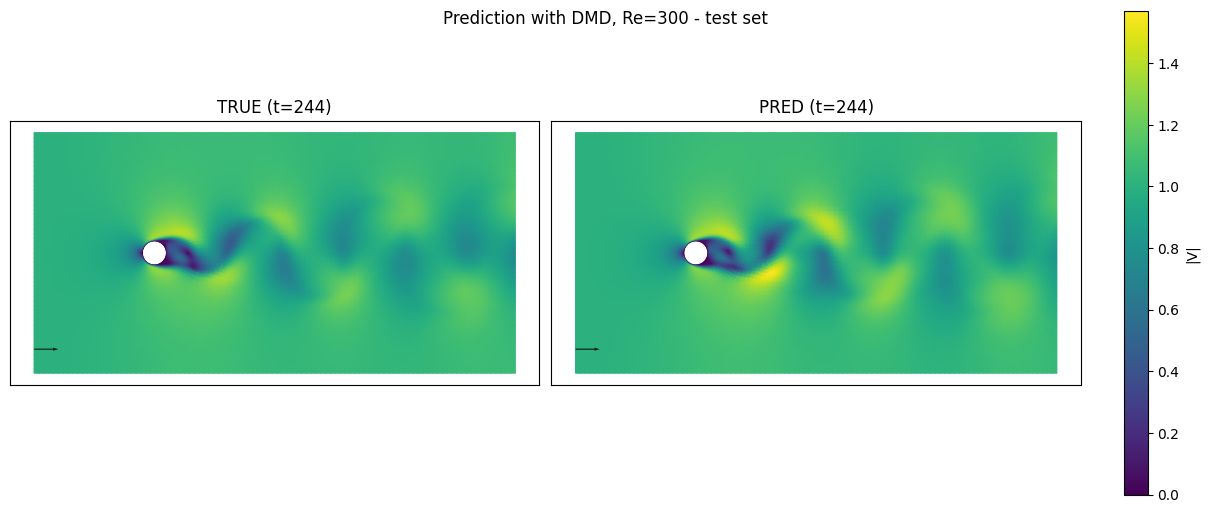

In [55]:

V_roll, V_step, e_roll, e_step = dmd_predict_modal_simple(
    Phi=Phi_sim,
    lambdas=eigvals_sim,
    V_test=V_test,
    #V_test=V_t,
    mean_train=V.mean(axis=1, keepdims=True),
    times=times_test
)

t_index = 244
fig = plot_velocity_true_vs_pred(tri, V_test, V_roll, t_index=t_index,
                                 layout="stacked", quiver_frac=0, R = '300 - test set')
plt.show()



In [56]:
t_index = 30
100 * np.linalg.norm(V_roll[:,t_index] - V_test[:,t_index])/np.linalg.norm(V_test[:,t_index])

np.float64(1.069003951044454)

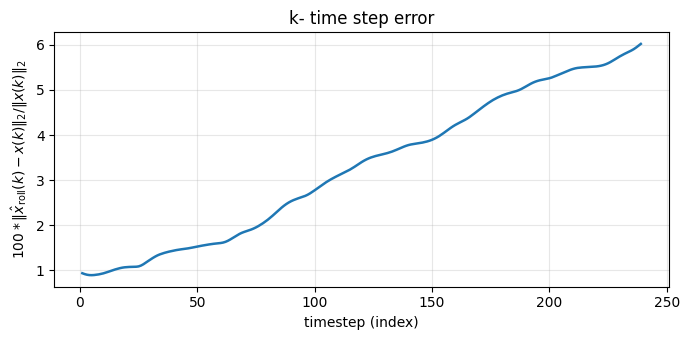

In [58]:
def plot_err_roll(err_roll, title="k- time step error", logy=False):
    """
    Plot rollout relative L2 error ε_roll(k) = ||x̂_roll(k) - x(k)||₂ / ||x(k)||₂
    x-axis is the timestep (frame) index.

    Args:
        err_roll : (T,) array; err_roll[0] is typically NaN (anchored at first frame).
        title    : figure title.
        logy     : if True, use a logarithmic y-scale.
    """
    err_roll = np.asarray(err_roll)
    k = np.arange(err_roll.size)
    mask = (k >= 1) & np.isfinite(err_roll)
    k = k[mask]
    e = err_roll[mask]

    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.plot(k, 100 *e, lw=1.8)
    if logy:
        ax.set_yscale('log')

    ax.set_xlabel("timestep (index)")
    ax.set_ylabel(r"$100 * \| \hat{x}_{\mathrm{roll}}(k)-x(k)\|_2 / \|x(k)\|_2$")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig, 100 *e
fig,rollout_err = plot_err_roll(e_roll[10:])
# plot_err_roll(err_roll, logy=True)
plt.show()

In [66]:
np.save(os.path.join(OUT_DIR  + f"DMD_rollout_error1.npz"), rollout_err)

In [24]:
def plot_err_step(err_step, title="One-step relative error vs timestep", logy=False):
    """
    Plot one-step relative L2 error ε(k) = ||x̂(k) - x(k)||₂ / ||x(k)||₂
    x-axis is the timestep index (frame index).

    Args:
        err_step : (T,) array; err_step[0] is typically NaN (anchored).
        title    : figure title.
        logy     : if True, use a log y-scale.
    """
    err_step = np.asarray(err_step)
    # Use k >= 1 and finite entries
    k = np.arange(err_step.size)
    mask = (k >= 1) & np.isfinite(err_step)
    k = k[mask]
    e = err_step[mask]

    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.plot(k, 100 * e, lw=1.8)
    if logy:
        ax.set_yscale('log')

    ax.set_xlabel("timestep (index)")
    ax.set_ylabel(r" Step Err:  100 *$\| \hat{x}(k)-x(k)\|_2 / \|x(k)\|_2$")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig


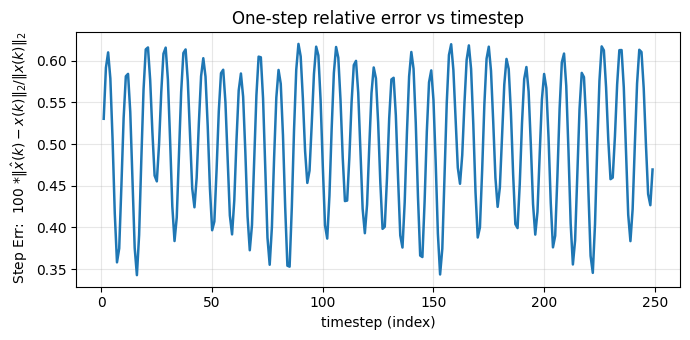

In [25]:
# After you run dmd_predict_modal_simple(...)
# _, _, err_roll, err_step = dmd_predict_modal_simple(...)

plot_err_step(e_step, logy=False)   # set logy=True if you prefer semilogy
plt.show()
